In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display # NOTE: will require ffmpeg installation
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import seaborn as sns
from scipy.stats import pearsonr
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes (for inset plots)
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset (for inset plots)
from xarrayutils.utils import linear_trend, xr_linregress
from eofs.standard import Eof

from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves
figures_folderpath = 'reports/figures/' # Folder for output figures

In [3]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

In [ ]:
##==================================================
##==============ANIMATION===========================
##==================================================
# Flux trend in time: Contourf animation

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})

# vmin=-0.000005
# vmax=0.0008

# Plot the initial frame.
# vmin = np.min(flux), vmax = np.max(flux) obtained manually. These should be modified to skip ocean flux values
cax = flux[1,:,:].plot(add_colorbar=True, 
                       cmap='coolwarm',
                       cbar_kwargs={'extend':'neither'})

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(flux[frame,:,:].values.flatten())
    ax.set_title("time = " + str(flux.coords['time'].values[frame])[:7])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=500,       # Could also be iterable or list
    interval=100     # ms between frames
)

In [ ]:
# View animation in browser / save to file
HTML(ani.to_jshtml())
# ani.save(inDirName+figures_folderpath+'AIS_flux.mp4')

In [ ]:
# Sample plot of AIS flux data
plt.figure(figsize=(12,8))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
flux[1000].plot()

In [16]:
# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [18]:
flux.rio.write_crs("epsg:3031",inplace=True);

In [ ]:
icems

<div align="right"><em>To-do: Isolate component polygons for Filchner, Ronne, E-Ross, Stange, W-Ross etc. that seem to be missing a separate <strong>region.geojson</strong> file</em></div>

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(icems.name)

In [14]:
ap = 3
wa = 4
ea = 5

apName = icems.name.values[ap]
waName = icems.name.values[wa]
eaName = icems.name.values[ea]

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
icems[34:133].boundary.plot(ax=ax,linewidth=0.5)
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[ap]].plot(ax=ax,color='r')
icems.loc[[wa]].plot(ax=ax,color='c')
icems.loc[[ea]].plot(ax=ax,color='b')

In [ ]:
# Mask data to chosen basins
apdata = data.rio.clip(icems.loc[[ap],'geometry'].apply(mapping),icems.crs,drop=False)
wadata = data.rio.clip(icems.loc[[wa],'geometry'].apply(mapping),icems.crs,drop=False)
eadata = data.rio.clip(icems.loc[[ea],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
apflux = apdata.timeMonthly_avg_landIceFreshwaterFlux
waflux = wadata.timeMonthly_avg_landIceFreshwaterFlux
eaflux = eadata.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
# Remove climatologies to isolate anomalies / deseasonalize 
apflux_month = apflux.groupby("time.month")
apflux_clm = apflux_month.mean("time") # Climatologies
apflux_anm = apflux_month - apflux_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
apflux_clm_ts = apflux_clm.sum(['y','x']) # Seasonality / Climatology?
apflux_anm_ts = apflux_anm.sum(['y','x'], skipna=True)

# Remove climatologies to isolate anomalies / deseasonalize 
waflux_month = waflux.groupby("time.month")
waflux_clm = waflux_month.mean("time") # Climatologies
waflux_anm = waflux_month - waflux_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
waflux_clm_ts = waflux_clm.sum(['y','x']) # Seasonality / Climatology?
waflux_anm_ts = waflux_anm.sum(['y','x'], skipna=True)

# Remove climatologies to isolate anomalies / deseasonalize 
eaflux_month = eaflux.groupby("time.month")
eaflux_clm = eaflux_month.mean("time") # Climatologies
eaflux_anm = eaflux_month - eaflux_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
eaflux_clm_ts = eaflux_clm.sum(['y','x']) # Seasonality / Climatology?
eaflux_anm_ts = eaflux_anm.sum(['y','x'], skipna=True)


In [5]:
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [6]:
apflux_anm_np = apflux_anm.to_numpy()
waflux_anm_np = waflux_anm.to_numpy()
eaflux_anm_np = eaflux_anm.to_numpy()

NameError: name 'apflux_anm' is not defined

In [7]:
flux_anm_np = flux_anm.to_numpy()
fluxsolver = Eof(flux_anm_np)

In [9]:
fluxeofs = fluxsolver.eofs()
fluxpcs = fluxsolver.pcs()

Text(0.5, 1.0, 'Temporal Std. Deviation of EOF modes')

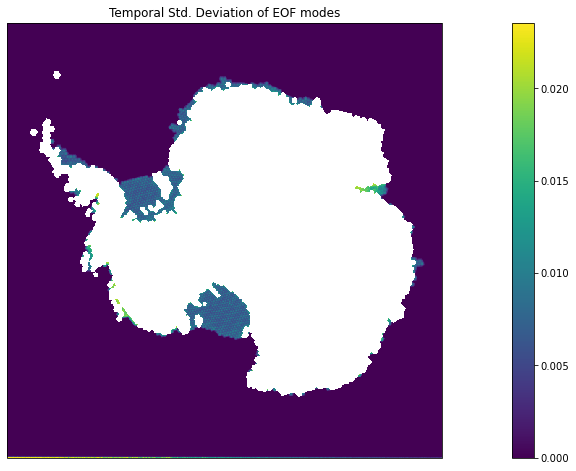

In [10]:
plt.figure(figsize=(25,8))
plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.coastlines(resolution='110m', zorder=6,linewidth=0.75)
plt.pcolormesh(fluxeofs.std(0)) #vmin=, vmax=
plt.colorbar()
plt.title('Temporal Std. Deviation of EOF modes')

In [11]:
fluxeofs_xr = xr.DataArray(fluxeofs, coords=flux.coords, dims=flux.dims, attrs=flux.attrs)

In [31]:
fluxpcs_xr = xr.DataArray(fluxpcs, dims=['mode','time'], attrs=flux.attrs)

In [30]:
ap_fluxpcs = flux.rio.clip(icems.loc[[ap],'geometry'].apply(mapping),icems.crs,drop=False)
wa_fluxpcs = flux.rio.clip(icems.loc[[wa],'geometry'].apply(mapping),icems.crs,drop=False)
ea_fluxpcs = flux.rio.clip(icems.loc[[ea],'geometry'].apply(mapping),icems.crs,drop=False)

(1800, 1800)

In [34]:
ap_fluxeofs = fluxeofs_xr.rio.clip(icems.loc[[ap],'geometry'].apply(mapping),icems.crs,drop=False)
wa_fluxeofs = fluxeofs_xr.rio.clip(icems.loc[[wa],'geometry'].apply(mapping),icems.crs,drop=False)
ea_fluxeofs = fluxeofs_xr.rio.clip(icems.loc[[ea],'geometry'].apply(mapping),icems.crs,drop=False)

In [39]:
ap_fluxeofs_std = ap_fluxeofs.std('time')
wa_fluxeofs_std = wa_fluxeofs.std('time')
ea_fluxeofs_std = ea_fluxeofs.std('time')

Text(0.5, 1.0, 'Temporal Std. Deviation of EOF modes')

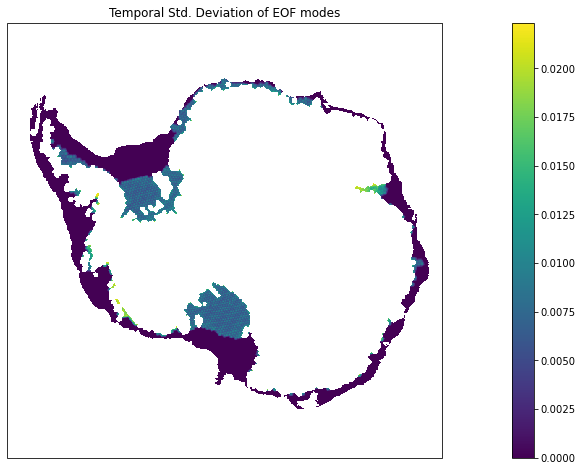

In [40]:
plt.figure(figsize=(25,8))
plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.coastlines(resolution='110m', zorder=6,linewidth=0.75)
plt.pcolormesh(ap_fluxeofs_std) #vmin=, vmax=
plt.pcolormesh(wa_fluxeofs_std)
plt.pcolormesh(ea_fluxeofs_std)
plt.colorbar()
plt.title('Temporal Std. Deviation of EOF modes')

In [33]:
fluxeofs_xr.rio.write_crs("epsg:3031",inplace=True);

In [90]:
ap_fluxeofsn = ap_fluxeofs.dropna('time',how='all')
ap_fluxeofsn = ap_fluxeofsn.dropna('y',how='all')
ap_fluxeofsn = ap_fluxeofsn.dropna('x',how='all')

In [91]:
wa_fluxeofsn = wa_fluxeofs.dropna('time',how='all')
wa_fluxeofsn = wa_fluxeofsn.dropna('y',how='all')
wa_fluxeofsn = wa_fluxeofsn.dropna('x',how='all')

In [ ]:
ea_fluxeofsn = ea_fluxeofs.dropna('time',how='all')
ea_fluxeofsn = ea_fluxeofsn.dropna('y',how='all')
ea_fluxeofsn = ea_fluxeofsn.dropna('x',how='all')

In [ ]:
ea_fluxeofs

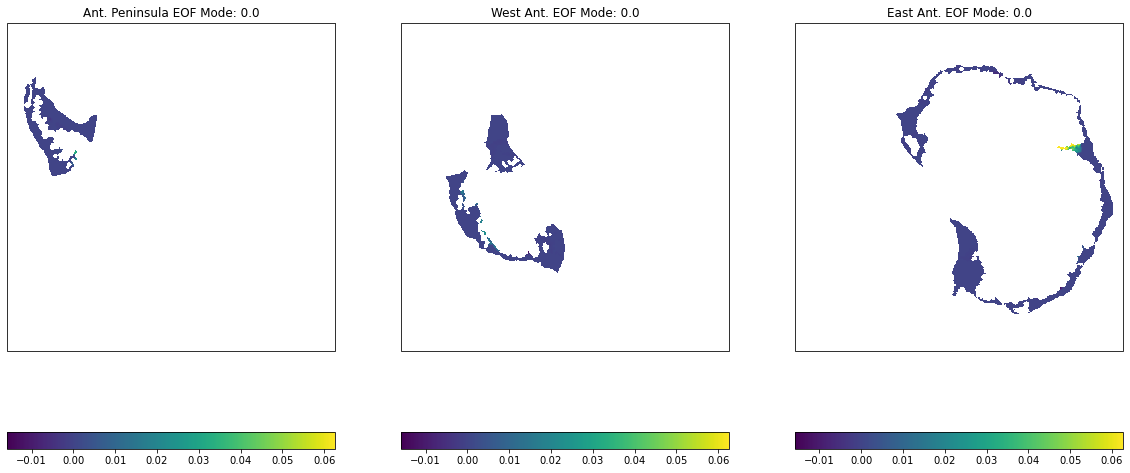

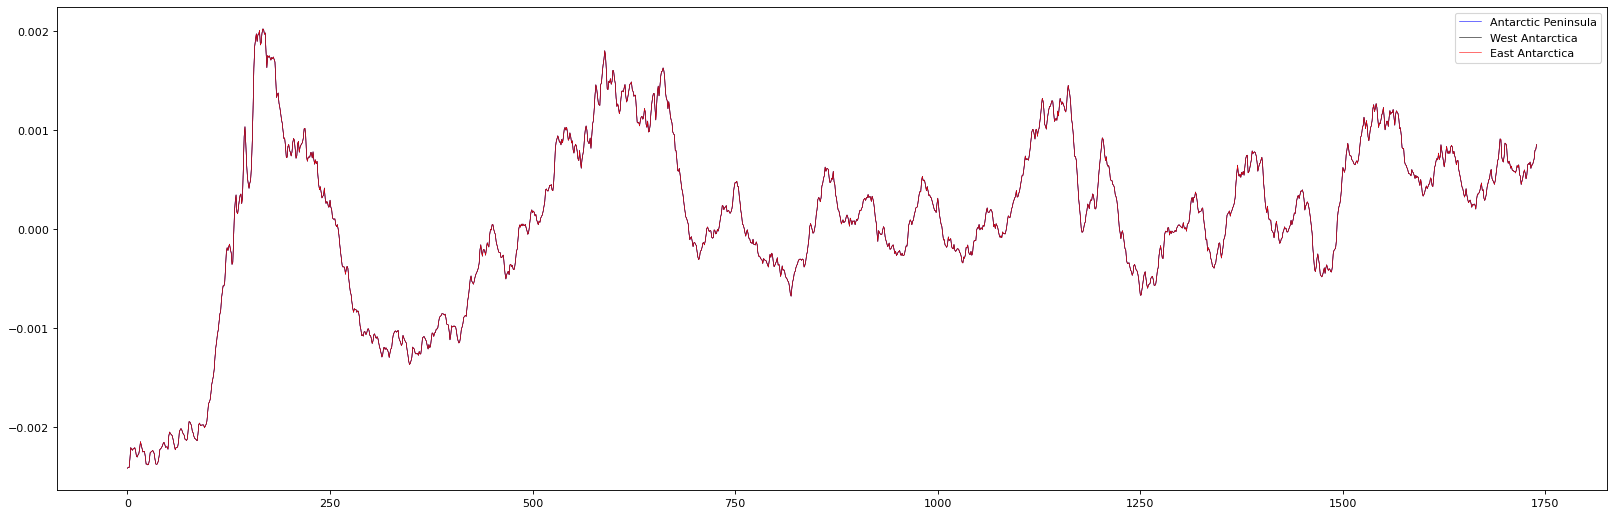

In [55]:
plt.figure(figsize=(20,10))

mode_number = 0

apvmin = np.nanmin(ap_fluxeofsn[mode_number])
wavmin = np.nanmin(wa_fluxeofsn[mode_number])
eavmin = np.nanmin(ea_fluxeofsn[mode_number])
vmin_global = np.nanmin([apvmin,wavmin,eavmin])

apvmax = np.nanmax(ap_fluxeofsn[mode_number])
wavmax = np.nanmax(wa_fluxeofsn[mode_number])
eavmax = np.nanmax(ea_fluxeofsn[mode_number])
vmax_global = np.nanmax([apvmax,wavmax,eavmax])



vmax_global = vmax_global/2


plt.subplot(131,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ap_fluxeofsn[mode_number],vmin=vmin_global,vmax=vmax_global) #vmin=, vmax=
plt.colorbar(orientation='horizontal')
plt.title('Ant. Peninsula EOF Mode: {:.1f}'.format(mode_number))
plt.subplot(132,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(wa_fluxeofsn[mode_number],vmin=vmin_global,vmax=vmax_global)
plt.colorbar(orientation='horizontal')
plt.title('West Ant. EOF Mode: {:.1f}'.format(mode_number))
plt.subplot(133,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ea_fluxeofsn[mode_number],vmin=vmin_global,vmax=vmax_global)
plt.colorbar(orientation='horizontal')
plt.title('East Ant. EOF Mode: {:.1f}'.format(mode_number))

plt.figure(figsize=(25,8), dpi=80)

y0= 5 # Year at start of time series visualization
yf= 200 # Year at end of time series visualization

t0= 12*y0
tf= 12*yf

plt.plot(fluxpcs[t0:tf,mode_number],label='Antarctic Peninsula',color='b',linewidth=0.5)
plt.plot(fluxpcs[t0:tf,mode_number],label='West Antarctica',color='k',linewidth=0.5)
plt.plot(fluxpcs[t0:tf,mode_number],label='East Antarctica',color='r',linewidth=0.5)
plt.legend()


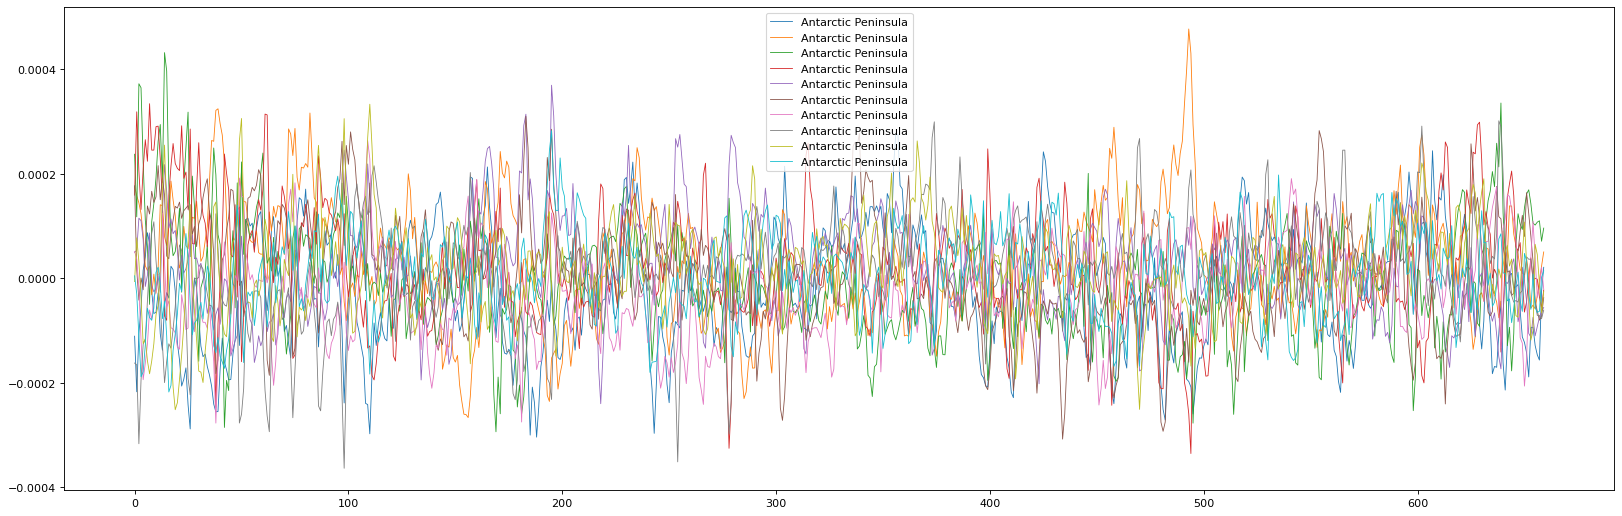

In [86]:
plt.figure(figsize=(25,8), dpi=80)

y0= 5 # Year at start of time series visualization
yf= 60 # Year at end of time series visualization

t0= 12*y0
tf= 12*yf

#plt.plot(fluxpcs[t0:tf,0:5],label='Antarctic Peninsula',linewidth=0.75)
plt.plot(fluxpcs[t0:tf,10:20],label='Antarctic Peninsula',linewidth=0.75)
plt.legend()

In [68]:
fluxeigenvalues = fluxsolver.eigenvalues()

In [72]:
flxeig_frac = fluxeigenvalues*100/sum(fluxeigenvalues)

In [83]:
sum(flxeig_frac[0:50])

95.81994581318104

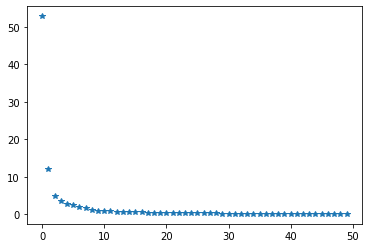

In [84]:
plt.plot(flxeig_frac[0:50],'*')

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.coastlines(resolution='110m', zorder=6,linewidth=0.75)
plt.pcolormesh(fluxeofs.std(0)) #vmin=, vmax=
plt.colorbar()

In [ ]:
apsolver = Eof(apflux_anm_np)
wasolver = Eof(waflux_anm_np)
easolver = Eof(eaflux_anm_np)

In [ ]:
ap_pcs = apsolver.pcs()
wa_pcs = wasolver.pcs()
ea_pcs = easolver.pcs()

In [ ]:
ap_eofs = apsolver.eofs()
wa_eofs = wasolver.eofs()
ea_eofs = easolver.eofs()

In [ ]:
# Std deviation of EOFs in time
ap_eofs_std = ap_eofs.std(0)
wa_eofs_std = wa_eofs.std(0)
ea_eofs_std = ea_eofs.std(0)

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.coastlines(resolution='110m', zorder=6,linewidth=0.75)
plt.pcolormesh(ap_eofs_std) #vmin=, vmax=
plt.pcolormesh(wa_eofs_std)
plt.pcolormesh(ea_eofs_std)
plt.colorbar()
plt.title('Temporal Std. Deviation of EOF modes')

In [ ]:
ap_eig = apsolver.eigenvalues()
wa_eig = wasolver.eigenvalues()
ea_eig = easolver.eigenvalues()

ap_eig_var = ap_eig/sum(ap_eig)*100
wa_eig_var = wa_eig/sum(wa_eig)*100
ea_eig_var = ea_eig/sum(ea_eig)*100

In [ ]:
plt.figure(figsize=(25,8))
plt.subplot(131)
plt.plot(ap_eig_var[0:20],'*',label='Ant. Peninsula')
plt.legend()
plt.subplot(132)
plt.plot(wa_eig_var[0:20],'*',label='West Ant.')
plt.legend()
plt.subplot(133)
plt.plot(ea_eig_var[0:20],'*',label='East Ant.')
plt.legend()

plt.suptitle('Relative Importance of Eigenvalues of EOF Decomposition')

In [ ]:
K=np.size(ap_pcs[:,1]) #number of EOF modes
fac = np.zeros(K)
for k in range(K):
    fac[k]=np.std(ap_pcs[k,:])
    ap_eofs[:,:,k]=ap_eofs[:,:,k]*fac[k]
    ap_pcs[k,:]=ap_pcs[k,:]/fac[k]
    

In [ ]:
plt.figure(figsize=(25,8), dpi=80)

y0= 5 # Year at start of time series visualization
yf= 200 # Year at end of time series visualization

t0= 12*y0
tf= 12*yf

plt.plot(ap_pcs[t0:tf,3:5],label='Antarctic Peninsula',color='b',linewidth=0.5)
plt.plot(wa_pcs[t0:tf,3:5],label='West Antarctica',color='k',linewidth=0.5)
plt.plot(ea_pcs[t0:tf,3:5],label='East Antarctica',color='r',linewidth=0.5)
plt.legend()

In [ ]:
plt.figure(figsize=(30,10))

mode_number = 4

plt.subplot(131,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ap_eofs[mode_number]) #vmin=, vmax=
plt.colorbar(orientation='horizontal')
plt.title('Ant. Peninsula EOF Mode: {:.1f}'.format(mode_number))
plt.subplot(132,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(wa_eofs[mode_number])
plt.colorbar(orientation='horizontal')
plt.title('West Ant. EOF Mode: {:.1f}'.format(mode_number))
plt.subplot(133,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ea_eofs[mode_number])
plt.colorbar(orientation='horizontal')
plt.title('East Ant. EOF Mode: {:.1f}'.format(mode_number))


plt.figure(figsize=(25,8), dpi=80)

y0= 5 # Year at start of time series visualization
yf= 200 # Year at end of time series visualization

t0= 12*y0
tf= 12*yf

plt.plot(ap_pcs[t0:tf,mode_number],label='Antarctic Peninsula',color='b',linewidth=0.5)
plt.plot(wa_pcs[t0:tf,mode_number],label='West Antarctica',color='k',linewidth=0.5)
plt.plot(ea_pcs[t0:tf,mode_number],label='East Antarctica',color='r',linewidth=0.5)
plt.legend()

In [ ]:
plt.figure(figsize=(20,10))

mode_number = 1

apvmin = np.nanmin(ap_eofs[mode_number])
wavmin = np.nanmin(wa_eofs[mode_number])
eavmin = np.nanmin(ea_eofs[mode_number])
vmin_global = np.nanmin([apvmin,wavmin,eavmin])

apvmax = np.nanmax(ap_eofs[mode_number])
wavmax = np.nanmax(wa_eofs[mode_number])
eavmax = np.nanmax(ea_eofs[mode_number])
vmax_global = np.nanmax([apvmax,wavmax,eavmax])


plt.subplot(131,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ap_eofs[mode_number],vmin=vmin_global,vmax=vmax_global) #vmin=, vmax=
plt.colorbar(orientation='horizontal')
plt.title('Ant. Peninsula EOF Mode: {:.1f}'.format(mode_number))
plt.subplot(132,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(wa_eofs[mode_number],vmin=vmin_global,vmax=vmax_global)
plt.colorbar(orientation='horizontal')
plt.title('West Ant. EOF Mode: {:.1f}'.format(mode_number))
plt.subplot(133,projection=ccrs.SouthPolarStereo())
plt.pcolormesh(ea_eofs[mode_number],vmin=vmin_global,vmax=vmax_global)
plt.colorbar(orientation='horizontal')
plt.title('East Ant. EOF Mode: {:.1f}'.format(mode_number))


plt.figure(figsize=(25,8), dpi=80)

y0= 5 # Year at start of time series visualization
yf= 200 # Year at end of time series visualization

t0= 12*y0
tf= 12*yf

plt.plot(ap_pcs[t0:tf,mode_number],label='Antarctic Peninsula',color='b',linewidth=0.5)
plt.plot(wa_pcs[t0:tf,mode_number],label='West Antarctica',color='k',linewidth=0.5)
plt.plot(ea_pcs[t0:tf,mode_number],label='East Antarctica',color='r',linewidth=0.5)
plt.legend()

In [ ]:
np.min(ap_eofs[mode_number])

In [ ]:
fluxsolver = Eof(data.timeMonthly_avg_landIceFreshwaterFlux.to_numpy())

In [ ]:
# Antarctic Peninsula
apdatan = apdata.dropna('x',how='all')
apdatan = apdatan.dropna('y',how='all')
apdatan = apdatan.dropna('time',how='all')

In [ ]:
# West Antarctica
wadatan = wadata.dropna('x',how='all')
wadatan = wadatan.dropna('y',how='all')
wadatan = wadatan.dropna('time',how='all')

In [ ]:
# East Antarctica
eadatan = eadata.dropna('x',how='all')
eadatan = eadatan.dropna('y',how='all')
eadatan = eadatan.dropna('time',how='all')

In [ ]:
## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne        #TODO: Split polygons for Ronne1, Ronne2 etc.
# 104 : Western Ross #TODO: Split polygons for W-Ross1, W-Ross2 etc.
# 105 : Eastern Ross #TODO: Split polygons for E-Ross1, E-Ross2 etc.
# 114 : Thwaites

basin = 34
basinName = icems.name.values[basin]

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
icems[34:133].boundary.plot(ax=ax,linewidth=0.5)
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax)

In [ ]:
# Mask data to chosen basin
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

In [ ]:
dsn = ds.dropna('x',how='all')
dsn = dsn.dropna('y',how='all')
dsn = dsn.dropna('time',how='all')

In [ ]:
flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

# Remove NaN values (speed up computation time)
flxnna = flx.dropna('x',how='all')
flxnna = flxnna.dropna('y',how='all')
flxnna = flxnna.dropna('time',how='all')

hnna = h.dropna('x',how='all')
hnna = hnna.dropna('y',how='all')
hnna = hnna.dropna('time',how='all')

In [ ]:
ds_tm = dsn.mean('time')

In [ ]:
ds_rgrs = xr_linregress(dsn.timeMonthly_avg_ssh, dsn.timeMonthly_avg_landIceFreshwaterFlux, dim='time')

In [ ]:
flxnna_tm = flxnna.mean('time')
hnna_tm = hnna.mean('time')

In [ ]:
flxn_rgrs = xr_linregress(hnna, flxnna, dim='time')

In [ ]:
for i in range(1800):
    plt.scatter(flxnna[i],hnna[i])
plt.xlabel('Flux')
plt.ylabel('Depth')

In [ ]:
flxn_prd = flxn_rgrs.slope*hnna.mean('time') + flxn_rgrs.intercept
#flxn_prd = flxn_prd.transpose('time','y','x')
flxn_ddrft = flx-flxn_prd

In [ ]:
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
#flxn_prd.plot()
#flxn_ddrft.mean('time').plot(levels=np.linspace(-2e-15,2e-15,20))
#flxn_ddrft.mean('time').plot()
#flxnna.mean('time').plot()

In [ ]:
flxn_rgrs.r_value.plot()

In [ ]:
# Stack data for ECM calculation, drop NaN values
flxnna_stck = flxnna.stack(pxl=['y','x'])
flxnna_stckna = flxnna_stck.dropna('pxl',how='all')

In [ ]:
solver = Eof(flux_np)

In [ ]:
flxn_std = dsn.timeMonthly_avg_landIceFreshwaterFlux.std('time')

In [ ]:
flxn_std.plot()

In [ ]:
flux_np = dsn.timeMonthly_avg_landIceFreshwaterFlux.to_numpy()

In [ ]:
pcs = solver.pcs()

In [ ]:
eofs = solver.eofs()

In [ ]:
dsn.timeMonthly_avg_landIceFreshwaterFlux

In [ ]:
eigenvalues = solver.eigenvalues()

In [ ]:
var_expl = eigenvalues/sum(eigenvalues)*100

In [ ]:
plt.plot(var_expl[0:10],'*')

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
plt.plot(pcs[:,0:10])

In [ ]:
sum(var_expl[0:2])

In [ ]:
# Fill empirical correlation matrix
data = np.zeros([788,788])
for i in range(788):
    data[i,:] = xr.corr(flxnna_stckna[:],flxnna_stckna[:,i],dim='time')

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
plt.imshow(data)
plt.colorbar()

In [ ]:
datan = data[np.logical_not(np.isnan(data))]

In [ ]:
# Representative pixel

pxl_means = np.nanmean(data,axis=0)
ind_pxl = np.where(pxl_means == np.nanmax(pxl_means))
rep_pxl = flxnna_stckna[:,ind_pxl[0]].unstack()

In [ ]:
rep_pxl

In [ ]:
datan = data[np.logical_not(np.isnan(data))]
datan = datan.reshape(int(np.sqrt(datan.size)),int(np.sqrt(datan.size)))
plt.figure(figsize=(20,10), dpi=80)
plt.pcolormesh(datan)
plt.colorbar()

In [ ]:
eof1 = solver.eofsAsCovariance(neofs=2)

In [ ]:
plt.figure(figsize=(20,20), dpi=80)
plt.imshow(data)
plt.colorbar()

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
plt.contourf(flxnna_stckna)
plt.colorbar()

In [ ]:
# Remove NaN values
fl_stack = flx.stack(s=['time','y','x']) # Reason for long runtimes?
fln = fl_stack[fl_stack.notnull()]
flxn = fln.unstack()
flxn_ts = flxn.sum(['x','y'])

In [ ]:
h_stack = h.stack(s=['time','y','x'])
hn = h_stack[h_stack.notnull()]
sshn = hn.unstack()

In [ ]:
flxn_stck = flxn.stack(z=['y','x'])
# flxn_stck = flxn_stck.fillna(0)

In [ ]:
# flxn_stck
# plt.imshow(flxn_stck, cmap='hot')
# sns.heatmap(flxn_stck,annot=True)
# for i in range(flxn_stck.time.size):

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
im = plt.imshow(flxn_stck, cmap='hot')
plt.colorbar(im)

In [ ]:
flxn_stckna = flxn_stck.dropna('z')

In [ ]:
flxnn = flxn_stckna.unstack()

In [ ]:
flxn_stckna

In [ ]:
plt.figure(figsize=(20,8), dpi=80)
for i in range(flxn_stckna.z.size):# range(flxn_stck.time.size):
    plt.plot(flxn_stck[:,i])
    plt.ylim([-3e-6,0.00064763])

In [ ]:
data = np.zeros([788,788])

for i in range(788):
    for j in range(788):
        data[i,j] = xr.corr(flxnna_stckna[:,i],flxnna_stckna[:,j])
        print('calculated...{},{}'.format(i,j))

In [ ]:
h.mean('time')

In [ ]:
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)

In [ ]:
corr = multi_apply_along_axis(pearsonr, 0, [flxn_stckna,flxn_stckna])
corr.shape

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,3))

p0 = axes[0].pcolormesh(corr[0,:])
plt.colorbar(p0, ax=axes[0])
axes[0].set_title('Pearson Correlation Coefficient')

p1 = axes[1].pcolormesh(numpy.log(corr[1,:]))
axes[1].set_title('Log p-value')
plt.colorbar(p1, ax=axes[1])

In [ ]:
corr.plot()

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
plt.imshow(data2)

In [ ]:
(601*601)**2

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
im = plt.imshow(data2)
plt.colorbar(im)

In [ ]:
plt.plot(flxn_stck[:,3])

In [ ]:
h.mean('time')

In [ ]:
flxn_rgrs = xr_linregress(h.mean('time'), flx.mean('time')) # h = independent variable
flxn_prd = flxn_rgrs.slope*h + flxn_rgrs.intercept
#flxn_prd = flxn_prd.transpose('time','y','x')
flxn_ddrft = flxnna - flxn_prd

In [ ]:
flxnna.mean('time')

In [ ]:
flxn_prd_ts = flxn_prd.sum(['x','y'])
flxn_ddrft_ts = flxn_ddrft.sum(['x','y'])

In [ ]:
fl_mean = flxnna.mean('time')

In [ ]:
flxnna.mean('time').plot()

In [ ]:
flxn_ddrft.mean('time').plot()

In [ ]:
plt.figure(figsize=(25, 8), dpi=80)
plt.plot(flxnna.sum(['y','x']))
plt.plot(flxn_prd_ts)
plt.plot(flxn_ddrft_ts)

In [ ]:
# spatial scaling factor
# done after dedrafting
# average over time for each pixel
# remove this (scale this in comparison to total average over catchment)

flxn_scl_fctr = flxn_ddrft.mean('time')
flxn_ts_mean = flxn_ddrft.mean(['y','x'])
#flxn_scl = flxn_ts_mean - flxn_scl_fctr
#flxn_scl = flxn_scl.transpose('time','y','x')

In [ ]:
flxn_scl = flxn_ddrft.mean()

In [ ]:
#fl_mean.plot()

flscl = fl_mean/flxnna.mean()

In [ ]:
# Original Flux data
plt.figure(figsize=(10,5), dpi=80)
flscl.plot()

In [ ]:
scl = flxn_scl/flxn_scl_fctr

In [ ]:
plt.figure(figsize=(10, 5), dpi=80)
scl.plot(levels=np.linspace(-3,3,40))

In [ ]:
# fig, ax = plt.subplots(figsize=(15,8), subplot_kw={'projection': ccrs.SouthPolarStereo()})
# ax.pcolormesh(flxn_scl_fctr.x, flxn_scl_fctr.y, flxn_scl_fctr)

In [ ]:
# Remove climatologies to isolate anomalies / deseasonalize 
flxn_monthly = flxn_scl.groupby("time.month")
flxn_clm = flxn_monthly.mean("time") # Climatologies
flxn_anm = flxn_monthly - flxn_clm # Deseasonalized anomalies

# Integrate over entire AIS / basin for time series
flxn_clm_ts = flxn_clm.sum(['y','x']) # Seasonality / Climatology?
flxn_anm_ts = flxn_anm.sum(['y','x'], skipna=True)


In [ ]:
# Annual Climatology
plt.figure(figsize=(8, 5), dpi=80)
plt.title('Climatology')
plt.plot(flxn_clm_ts,color='m', linestyle='dotted', linewidth=1)
plt.ylabel('landIceFreshwaterFlux')
plt.xlabel('Month')

In [ ]:
flxn_diff = flxn_ddrft_ts - flxn_anm_ts

In [ ]:
plt.figure(figsize=(25, 10), dpi=80)
plt.plot(flxn_ts, label='Original MPAS Output', color='g', linestyle='-', linewidth=0.75)
plt.plot(flxn_prd_ts, label='Predicted MPAS Output (Draft Regressed)', color='m', linestyle='--', linewidth=0.65)
plt.plot(flxn_ddrft_ts, label='Dedrafted MPAS Output', color='y', linestyle='-', linewidth=0.95)
plt.plot(flxn_anm_ts, label='Seasonal Anomalies', color='r', linestyle='dotted', linewidth=0.95)
plt.plot(flxn_diff, label='Seasonal Cycle', color='b', linestyle='-', linewidth=0.45)
plt.legend()

In [ ]:
# Plot phase randomized data
plt.figure(figsize=(25, 8), dpi=80)

spinuptime = 100 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flxn_anm_ts[spinuptime:].size))

# Time limits for plotting
t1 = 60
tf = 800

for i in range(n_realizations):    
    fl = flxn_anm_ts[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [ ]:
flx_tmean = flx.mean('time')
h_tmean = h.mean('time')

In [ ]:
flx_ts_mean = flx.mean(['y','x'])

In [ ]:
plt.figure(figsize=(7, 8), dpi=80)

plt.scatter(flx_tmean,h_tmean)
plt.xlabel('Flux')
plt.ylabel('Sea Surface Height (m)')
plt.title('Mean Flux vs. Mean SSH')

In [ ]:
# Linear regression along 'time': flux and ssh
t1 = 120 # Remove model "spinup" data
flx_rgrs = xr_linregress(h[t1:], flx_nna[t1:], dim='time') # h = independent variable

In [ ]:
flx_prd = flx_rgrs.slope*h + flx_rgrs.intercept

In [ ]:
flx_prd = flx_prd.transpose('time','y','x')

In [ ]:
flx_ddrft = flx - flx_prd

In [ ]:
flx_trend = linear_trend(flx, 'time')


In [ ]:
flx_trend

In [ ]:
plt.figure(figsize=(30, 5), dpi=80)
flx_ts_mean.plot()

In [ ]:
flx_ts.groupby('time.month')

In [ ]:
month_length = flx_ts.time.dt.days_in_month
flx_ts

In [ ]:

da_stacked = flx.stack(z=['x','y','time'])
da_stacked[da_stacked.notnull()]

In [ ]:
plt.figure(figsize=(30, 5), dpi=80)
melt_ts = flx_ts*month_length*24*60*60*100*20*1e6/1e12 # GT/year #Factor of 20?
melt_ts.plot()

In [ ]:
melt_ts = flx_ts*month_length
melt_ts

In [ ]:
flx_ts[0]*month_length[0]

In [ ]:
flx_prd_ts = flx_prd.sum(['y','x'])

In [ ]:
flx_ddrft_ts = flx_ddrft.sum(['y','x'])

In [ ]:
flx_prd_ts = flx_prd.mean(['y','x'])
flx_ddrft_ts = flx_ddrft.mean(['y','x'])

In [ ]:
flx_ts = flx.mean(['y','x'])

In [ ]:
flx_ts = flx.sum(['y','x'])

In [ ]:
flx_stck = flx.stack(z=['time','x','y'])
flx_notnull = flx_stck[flx_stck.notnull()] # REMOVE EXTERNAL NAN VALUES WHILE CALCULATING TIME SERIES (Stacked dimensions can be unstacked)
# TODO: Reset coordinates after unstacking to plot maps incorporating rest of continent/AIS

In [ ]:
flx_nna = flx_notnull.unstack()

In [ ]:
flx_nna_ts = flx_nna.sum(['y','x'])

In [ ]:
flx_nna_ts.plot()

In [ ]:
flx_ts.plot()

In [ ]:
plt.figure(figsize=(25, 8), dpi=80)
plt.plot(flx_ts)
plt.plot(flx_prd_ts)
plt.plot(flx_ddrft_ts)

In [ ]:
# spatial scaling factor
# done after dedrafting
# average over time for each pixel
# remove this (scale this in comparison to total average over catchment)

flx_scl_fctr = flx_ddrft.mean('time')

In [ ]:
flx_ts_mean = flx_ddrft.mean(['y','x'])

In [ ]:
flx_scaled.shape

In [ ]:
flx_ts_mean.shape

In [ ]:
flx_scl = flx_scl_fctr/flx_ts_mean

In [ ]:
flx_scl = flx_scl_fctr/flx_ddrft_ts

In [ ]:
flx_scl = flx_scl.transpose('time','y','x')

In [ ]:
# PCA decomposition

In [ ]:
# Presents a sample plot of the ice shelf under question with the flux data at any time stamp
 
# Time stamp
ts = 200

plt.figure(figsize=(15,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
ax.coastlines(resolution='10m',linewidth=0.75)
flx[ts].plot.contourf(ax=ax,levels=30,zorder=6)
icems.boundary.loc[[basin]].plot(ax=ax,color='blue',linewidth=0.25)

In [ ]:
# Remove climatologies to isolate anomalies / deseasonalize 
flx_monthly = flx_ddrft.groupby("time.month")
flx_clm = flx_monthly.mean("time") # Climatologies
flx_anm = flx_monthly - flx_clm # Deseasonalized anomalies



In [ ]:
# Integrate over entire AIS / basin for time series
flx_clm_ts = flx_clm.mean(['y','x']) # Seasonality / Climatology?
flx_anm_ts = flx_anm.mean(['y','x'], skipna=True)

In [ ]:
# Integrate over entire AIS / basin for time series
flx_clm_ts = flx_clm.sum(['y','x']) # Seasonality / Climatology?
flx_anm_ts = flx_anm.sum(['y','x'], skipna=True)

In [ ]:
# Annual Climatology
plt.figure(figsize=(8, 5), dpi=80)
plt.title('Climatology')
plt.plot(flx_clm_ts,color='m', linestyle='dotted', linewidth=1)
plt.ylabel('landIceFreshwaterFlux')
plt.xlabel('Month')

In [ ]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [ ]:
def detrend(da, dims, deg=1):
    # detrend along multiple dimensions
    # only valid for linear detrending (deg=1)
    da_detrended = da
    for dim in dims:
        da_detrended = detrend_dim(da_detrended, dim, deg=deg)
    return da_detrended

In [ ]:
flx_tmean = flx.mean('time')
flx_prd_tmean = flx_prd.mean('time')
flx_ddrft_tmean = flx_ddrft.mean('time')
# h_tmean = h.mean('time')

In [ ]:
t = 100
plt.scatter(flx_tmean,h[t], label="Flux: Original MPAS Output")
plt.scatter(flx_prd_tmean,h[t], label="Flux: Predicted MPAS Output (Draft Regressed)")
plt.scatter(flx_ddrft_tmean,h[t], label="Dedrafted Flux")
plt.legend()

In [ ]:
t=1000
plt.scatter(flx[t],h[t], label="Flux: Original MPAS Output")
plt.scatter(flx_prd[:,:,t],h[t], label="Flux: Predicted MPAS Output (Draft Regressed)")
plt.scatter(flx_ddrft[t],h[t], label="Dedrafted Flux")
plt.legend()

In [ ]:
# Remove linear trend from the deseasonalized anomalies
flx_dtr = detrend_dim(flx_anm, 'time', 1)

In [ ]:
# Integrate flux across basin for time series
flx_dtr_ts = flx_dtr.sum(['y','x'], skipna=True)

In [ ]:
flx_snl_ts = flx_ddrft_ts - flx_anm_ts # Seasonality trend
flx_lnr_ts = flx_anm_ts - flx_dtr_ts # Linear trend

In [ ]:
plt.figure(figsize=(25, 10), dpi=80)
plt.plot(flx_ts, label='Original MPAS Output', color='g', linestyle='-', linewidth=0.75)
plt.plot(flx_prd_ts, label='Predicted MPAS Output (Draft Regressed)', color='m', linestyle='--', linewidth=0.65)
plt.plot(flx_ddrft_ts, label='Dedrafted MPAS Output', color='y', linestyle='-', linewidth=0.95)
plt.plot(flx_anm_ts, label='Seasonal Anomalies', color='r', linestyle='dotted', linewidth=0.95)
plt.plot(flx_dtr_ts, label='Deseasonalized and Linearly Detrended Data', color='k', linewidth=1)
plt.plot(flx_snl_ts, label='Seasonal Cycle', color='c', linestyle='dotted', linewidth=0.95)
plt.legend()

In [ ]:
# Seasonal and Linear Trend Decomposition

plt.subplots(3, figsize=(30, 18), dpi=80)
plt.suptitle('Seasonal and Linear Trend Decomposition')

plt.subplot(311)
flx_dtr_ts.plot(color='k', linewidth=2)
plt.title('Deseasonalized and Detrended Data')

plt.subplot(312)
flx_lnr_ts.plot(color='r', linestyle='--', linewidth=0.95)
plt.ylabel('Linear Trend')
plt.title('')

plt.subplot(313)
flx_snl_ts.plot(color='m', linestyle='dotted', linewidth=0.95)
plt.ylabel('Seasonal Cycle')
plt.title('')

In [ ]:
# Plot phase randomized data
plt.figure(figsize=(25, 8), dpi=80)

spinuptime = 100 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_dtr_ts[spinuptime:].size))

# Time limits for plotting
t1 = 60
tf = 800

for i in range(n_realizations):    
    fl = flx_dtr_ts[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized and Detrended Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [ ]:
# Time Series Plotting Parameters
spinuptime = 0 # Ignore first few years of data in the time series and phase randomization plots, assumed model spinup
t1 = 500 # Initial time limit
tf = 900 # Final time limit, also used in the sample contourf plot


###########################################################
########## MAP PLOTS
###########################################################

plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax1)
plt.title('Catchment Boundaries')

# Presents a sample plot of the ice shelf under question with the flux data at any time stamp

ax2 = plt.subplot(122,projection=ccrs.SouthPolarStereo())
ax2.gridlines()
ax2.coastlines(resolution='10m', zorder=3,linewidth=0.75)
flx[tf].plot.contourf(ax=ax2,levels=30,zorder=6)
icems.boundary.loc[[basin]].plot(ax=ax2,color='blue',linewidth=0.25)
plt.title('Sample Data Masked to Catchment: {}'.format(basinName))


###########################################################
########## TIME SERIES PLOTS
###########################################################
plt.figure(figsize=(30, 24), dpi=80)

plt.subplot(311)
plt.plot(flx_ts[(spinuptime+t1):tf], label='Original MPAS Output', color='b', linestyle='--', linewidth=0.95)
plt.plot(flx_anm_ts[(spinuptime+t1):tf], label='Seasonal Anomalies', color='r', linestyle='dotted', linewidth=0.95)
plt.plot(flx_prd_ts[(spinuptime+t1):tf], label='Predicted MPAS Output (Draft Regressed)', color='m', linestyle='--', linewidth=0.65)
plt.plot(flx_dtr_ts[(spinuptime+t1):tf], label='Deseasonalized and Linearly Detrended Data', color='k', linewidth=2)
plt.legend()
plt.title('Data Time Series: Comparison')


plt.subplot(312)
plt.plot(flx_dtr_ts[(spinuptime+t1):tf], label='Deseasonalized and Detrended Data', color='k', linewidth=2)
plt.plot(flx_lnr_ts[(spinuptime+t1):tf], label='Linear Trend', color='r', linestyle='--', linewidth=0.95)
plt.plot(flx_snl_ts[(spinuptime+t1):tf], label='Seasonal Cycle', color='m', linestyle='dotted', linewidth=0.95)
plt.legend()
plt.title('Seasonal and Linear Trend Decomposition')

plt.subplot(313)

n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_dtr_ts[spinuptime:].size))

for i in range(n_realizations):    
    fl = flx_dtr_ts[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Outputs')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Deseasonalized and Dedrafted Output')
plt.title('Deseasonalized and Dedrafted Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()

In [ ]:
from eofs.xarray import Eof

In [ ]:
flx_solver = Eof(flx)

In [ ]:
import seaborn as sns

In [ ]:
pcs = flx_solver.pcs()

In [ ]:
eofs = flx_solver.eofs()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
def regress_many(x, y, axis=0):
    """
    Regress y on x.

    x is a 1-D array or masked array with n points.
    y is at least 1-D, with n points along the dimension
    specified by axis.

    Returns (b1, r), where b1 is the slope and r is the correlation
    coefficient.
    """
    # Allow masked arrays and ordinary arrays, and remove the means.
    x = np.asanyarray(x)
    x -= x.mean()
    y = np.asanyarray(y)
    y -= y.mean(axis=axis, keepdims=True)
    
    # Black magic to accomodate any dimensionality of y:
    bc = tuple([slice(None) if i == axis else np.newaxis 
               for i in range(y.ndim)])
    
    # Note that we need only sums of squares and products.
    Sxx = (x**2).sum()
    Syy = (y**2).sum(axis=axis)
    Sxy = (x[bc] * y).sum(axis=axis)
    
    r = Sxy / np.ma.sqrt(Sxx * Syy)
    b1 = Sxy / Sxx
    
    return b1, r

In [ ]:


# plot autocorrelation
plt.figure(figsize=(20, 8), dpi=80)

fl = flx_dtr_ts[80:]
plt.clf()
fl_fourier = np.fft.rfft(fl)

random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
# random_phases = np.exp(np.random.uniform(0,2*np.pi)*1.0j)
fl_fourier_new = fl_fourier*random_phases
new_fl = np.fft.irfft(fl_fourier_new)
pd.plotting.autocorrelation_plot(fl)
pd.plotting.autocorrelation_plot(new_fl)
plt.ylabel('Autocorrelation')
plt.title('ACF: {}, Dedrafted & Deseasonalized'.format(basinName))
#plt.savefig('{}_flux_ACF_dedrafted.png'.format(basinName))
